# Presentation Attack Detection with Convolutional Neural Network

In this notebook, the convolutional neural network is performed to capture the presentation attacks. 

## Install and Import Required Packages

In [2]:
!pip install -r requirements.txt
!pip install pybase64

In [3]:
from google.oauth2 import service_account
import gcsfs
from PIL import Image
import io
import matplotlib.pyplot as plt
from IPython import display
import base64
from base64 import b64decode
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras 

## Pull Images from Cloud

In [4]:
def stringToRGB(base64_string):
    imgdata = base64.b64decode(base64_string)
    image = Image.open(io.BytesIO(imgdata))
    return np.array(image)

key_path = "cda-gatech-0f0f7b5092d0.json"
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

fs = gcsfs.GCSFileSystem(project='CDA-GATECH', token=credentials)

In [ ]:
images = []
labels = []
for v in fs.ls('cda-project/images/test/p')[1:]:
    if '/.' not in v:
        with fs.open(v) as f:
            b64 = base64.b64encode(f.read())
            img = stringToRGB(b64)
            if img.shape[0] == img.shape[1] == 100:
              images.append(img)
              labels.append(1)
for v in fs.ls('cda-project/images/test/n')[1:]:
    if '/.' not in v:
        with fs.open(v) as f:
            b64 = base64.b64encode(f.read())
            img = stringToRGB(b64)
            if img.shape[0] == img.shape[1] == 100:
              images.append(img)
              labels.append(0)
images = np.asarray(images)
labels = np.asarray(labels)
np.save('training_images.npy', images)
np.save('training_labels.npy', labels)

In [5]:
images = np.load('training_images.npy') # First 1323 images are not presentation attack
labels = np.load('training_labels.npy') # The remaining images are presentation attack

## Split the Data into Train and Test, and Rescale the Images

In [6]:
def train_test_data(image, label, non_attack = 1323):
  labels_pos = label[:non_attack]
  labels_neg = label[non_attack:]
  images_pos = image[:non_attack]
  images_neg = image[non_attack:]

  # Percentages of attack and non-attack images are same in train  and test sets 
  X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(images_pos, labels_pos, test_size=0.2, random_state=32)
  X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(images_neg, labels_neg, test_size=0.2, random_state=32)

  X_train = np.concatenate((X_train_pos, X_train_neg), axis=0)
  X_test =  np.concatenate((X_test_pos, X_test_neg), axis=0)
  y_train = np.concatenate((y_train_pos, y_train_neg), axis=0)
  y_test =  np.concatenate((y_test_pos, y_test_neg), axis=0)

  # Rescale the images from values between 0 and 255 to values between 0 and 1
  X_train = X_train/255.0
  X_test = X_test/255.0

  return X_train, y_train, X_test, y_test

## Create the Model

In [7]:
def keras_model(batch_size, epochs, img_height = 100, img_width = 100):

  # call train_test_data()
  X_train, y_train, X_test, y_test = train_test_data(images, labels)

  model = Sequential([
    Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(img_height, img_width ,3)),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
  ])

  model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
  
  # Augmentation --- Augment the training data to generate more images by using random transformations
  # This method will overcome the problem of overfitting due to insufficient number of training data
  datagen = ImageDataGenerator(rotation_range=45, 
                               width_shift_range=0.15,
	                             height_shift_range=0.15,
                               zoom_range=0.5,
	                             horizontal_flip=True) 
  
  training_generator = datagen.flow(X_train, y_train, batch_size = batch_size)

  H = model.fit(training_generator,
                steps_per_epoch=(len(X_train)*0.8)// batch_size, 
                epochs = epochs, 
                validation_data = (X_test, y_test), 
                verbose = 1)  
  
  score = model.evaluate(X_test, y_test, verbose=0)

  return H, score[1] * 100

In [8]:
history, test_acc = keras_model(256, 10)

Epoch 1/10
43/43 [==============================] - 126s 3s/step - loss: 0.2654 - accuracy: 0.9235 - val_loss: 0.1749 - val_accuracy: 0.9237
Epoch 2/10
43/43 [==============================] - 125s 3s/step - loss: 0.1736 - accuracy: 0.9232 - val_loss: 0.1594 - val_accuracy: 0.9237
Epoch 3/10
43/43 [==============================] - 126s 3s/step - loss: 0.1377 - accuracy: 0.9334 - val_loss: 0.1763 - val_accuracy: 0.9295
Epoch 4/10
43/43 [==============================] - 126s 3s/step - loss: 0.1064 - accuracy: 0.9586 - val_loss: 0.1957 - val_accuracy: 0.9375
Epoch 5/10
43/43 [==============================] - 132s 3s/step - loss: 0.0875 - accuracy: 0.9666 - val_loss: 0.1068 - val_accuracy: 0.9528
Epoch 6/10
43/43 [==============================] - 129s 3s/step - loss: 0.0801 - accuracy: 0.9690 - val_loss: 0.0677 - val_accuracy: 0.9600
Epoch 7/10
43/43 [==============================] - 129s 3s/step - loss: 0.0619 - accuracy: 0.9740 - val_loss: 0.0918 - val_accuracy: 0.9545
Epoch 8/10
43

In [9]:
print('Test accuracy: {:0.2f}%'.format(test_acc))

Test accuracy: 95.62%


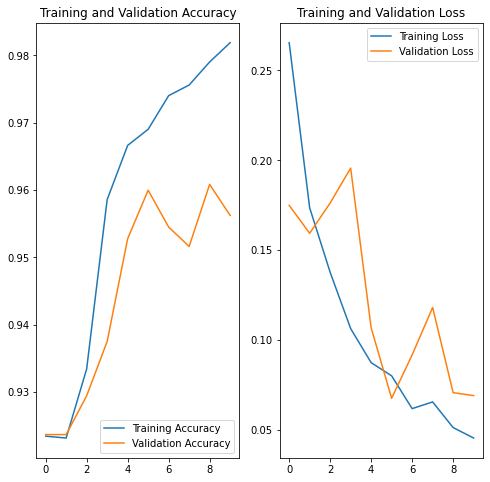

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()